Automatically created module for IPython interactive environment
Training MLPRegressor...
Training GradientBoostingRegressor...
Computing partial dependence plots...
Custom 3d plot via ``partial_dependence``


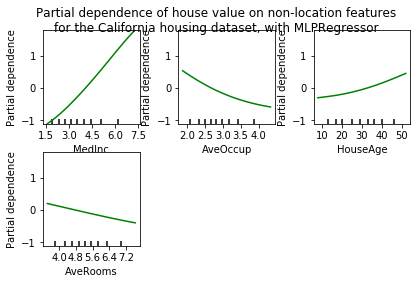

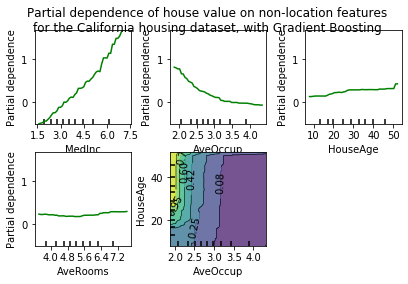

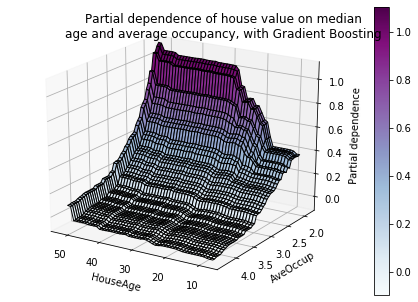

In [35]:
print(__doc__)

import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

from sklearn.inspection import partial_dependence
from sklearn.inspection import plot_partial_dependence
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.neural_network import MLPRegressor
from sklearn.datasets.california_housing import fetch_california_housing

def main():
    cal_housing = fetch_california_housing()

    X, y = cal_housing.data, cal_housing.target
    names = cal_housing.feature_names
    
    y -= y.mean()

    print("Training MLPRegressor...")
    est = MLPRegressor(activation='logistic')
    est.fit(X, y)
    
    features = [0, 5, 1, 2]
    plot_partial_dependence(est, X, features, feature_names=names,
                            n_jobs=3, grid_resolution=50)
    fig = plt.gcf()
    fig.suptitle('Partial dependence of house value on non-location features\n'
                 'for the California housing dataset, with MLPRegressor')
    plt.subplots_adjust(top=0.9)
    
    
    print("Training GradientBoostingRegressor...")
    est = GradientBoostingRegressor(n_estimators=100, max_depth=4,
                                    learning_rate=0.1, loss='huber',
                                    random_state=1)
    est.fit(X, y)
    print('Computing partial dependence plots...')
    features = [0, 5, 1, 2, (5, 1)]
    plot_partial_dependence(est, X, features, feature_names=names,
                            n_jobs=3, grid_resolution=50)
    fig = plt.gcf()
    fig.suptitle('Partial dependence of house value on non-location features\n'
                 'for the California housing dataset, with Gradient Boosting')
    plt.subplots_adjust(top=0.9)
    
    print('Custom 3d plot via ``partial_dependence``')
    fig = plt.figure()
    
    target_feature = (1, 5)
    pdp, axes = partial_dependence(est, X, target_feature,
                                   grid_resolution=50)
    XX, YY = np.meshgrid(axes[0], axes[1])
    Z = pdp[0].T
    ax = Axes3D(fig)
    surf = ax.plot_surface(XX, YY, Z, rstride=1, cstride=1,
                           cmap=plt.cm.BuPu, edgecolor='k')
    ax.set_xlabel(names[target_feature[0]])
    ax.set_ylabel(names[target_feature[1]])
    ax.set_zlabel('Partial dependence')
    #  pretty init view
    ax.view_init(elev=22, azim=122)
    plt.colorbar(surf)
    plt.suptitle('Partial dependence of house value on median\n'
                 'age and average occupancy, with Gradient Boosting')
    plt.subplots_adjust(top=0.9)

    plt.show()
    
if __name__ == '__main__':
    main()

In [42]:
from time import time

from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.decomposition import NMF, LatentDirichletAllocation
from sklearn.datasets import fetch_20newsgroups


n_samples = 2000
n_features = 1000
n_components = 10
n_top_words = 20


def print_top_words(model, feature_names, n_top_words):
    for topic_idx, topic in enumerate(model.components_):
        message = "Topic #%d: " % topic_idx
        message += " ".join([feature_names[i]
                             for i in topic.argsort()[:-n_top_words - 1:-1]])
        print(message)
    print()

    
print("Loading dataset...")
t0 = time()
dataset = fetch_20newsgroups(shuffle=True, random_state=1,
                             remove=('headers', 'footers', 'quotes'))
data_samples = dataset.data[:n_samples]
print("done in %0.3fs." % (time() - t0))

# Use tf-idf features for NMF.
print("Extracting tf-idf features for NMF...")
tfidf_vectorizer = TfidfVectorizer(max_df=0.95, min_df=2,
                                   max_features=n_features,
                                   stop_words='english')
t0 = time()
tfidf = tfidf_vectorizer.fit_transform(data_samples)
print("done in %0.3fs." % (time() - t0))

print("Extracting tf features for LDA...")
tf_vectorizer = CountVectorizer(max_df=0.95, min_df=2,
                                max_features=n_features,
                                stop_words='english')
t0 = time()
tf = tf_vectorizer.fit_transform(data_samples)
print("done in %0.3fs." % (time() - t0))
print()

print("Fitting the NMF model (Frobenius norm) with tf-idf features, "
      "n_samples=%d and n_features=%d..."
      % (n_samples, n_features))
t0 = time()
nmf = NMF(n_components=n_components, random_state=1,
          alpha=.1, l1_ratio=.5).fit(tfidf)
print("done in %0.3fs." % (time() - t0))

print("\nTopics in NMF model (Frobenius norm):")
tfidf_feature_names = tfidf_vectorizer.get_feature_names()
print_top_words(nmf, tfidf_feature_names, n_top_words)

print("Fitting the NMF model (generalized Kullback-Leibler divergence) with "
      "tf-idf features, n_samples=%d and n_features=%d..."
      % (n_samples, n_features))
t0 = time()
nmf = NMF(n_components=n_components, random_state=1,
          beta_loss='kullback-leibler', solver='mu', max_iter=1000, alpha=.1,
          l1_ratio=.5).fit(tfidf)
print("done in %0.3fs." % (time() - t0))

print("\nTopics in NMF model (generalized Kullback-Leibler divergence):")
tfidf_feature_names = tfidf_vectorizer.get_feature_names()
print_top_words(nmf, tfidf_feature_names, n_top_words)

print("Fitting LDA models with tf features, "
      "n_samples=%d and n_features=%d..."
      % (n_samples, n_features))
lda = LatentDirichletAllocation(n_components=n_components, max_iter=5,
                                learning_method='online',
                                learning_offset=50.,
                                random_state=0)
t0 = time()
lda.fit(tf)
print("done in %0.3fs." % (time() - t0))

print("\nTopics in LDA model:")
tf_feature_names = tf_vectorizer.get_feature_names()
print_top_words(lda, tf_feature_names, n_top_words)

Loading dataset...
done in 1.701s.
Extracting tf-idf features for NMF...
done in 0.507s.
Extracting tf features for LDA...
done in 0.563s.

Fitting the NMF model (Frobenius norm) with tf-idf features, n_samples=2000 and n_features=1000...
done in 0.401s.

Topics in NMF model (Frobenius norm):
Topic #0: just people don think like know time good make way really say right ve want did ll new use years
Topic #1: windows use dos using window program os drivers application help software pc running ms screen files version card code work
Topic #2: god jesus bible faith christian christ christians does heaven sin believe lord life church mary atheism belief human love religion
Topic #3: thanks know does mail advance hi info interested email anybody looking card help like appreciated information send list video need
Topic #4: car cars tires miles 00 new engine insurance price condition oil power speed good 000 brake year models used bought
Topic #5: edu soon com send university internet mit ftp m